# Modelo de Severidad - Responsabilidad Civil
## Competencia CAS y ACTEX 2025

Este notebook desarrolla un modelo de severidad para la cobertura de Responsabilidad Civil usando solo los registros que tuvieron siniestros (rc_siniestrados.csv).

**Variable objetivo**: `Resp_Civil_siniestros_monto`

In [1]:
# Librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, 
    TweedieRegressor, GammaRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib
import lazypredict
from lazypredict.Supervised import LazyRegressor

print("Librerías cargadas exitosamente")

Librerías cargadas exitosamente


In [2]:
# Cargar datos
data = pd.read_csv('/home/ge-murillo/Proyectos/competencia-cas-2025/data/processed/rc_siniestrados.csv')

print(f"Forma del dataset: {data.shape}")
print(f"\nPrimeras 5 filas:")
data.head()

Forma del dataset: (67, 15)

Primeras 5 filas:


,año_cursado,estudios_area,calif_promedio,2_o_mas_inquilinos,distancia_al_campus,genero,extintor_incendios,Gastos_Adicionales_siniestros_num,Gastos_Adicionales_siniestros_monto,Gastos_Medicos_RC_siniestros_num,Gastos_Medicos_RC_siniestros_monto,Resp_Civil_siniestros_num,Resp_Civil_siniestros_monto,Contenidos_siniestros_num,Contenidos_siniestros_monto
0,4to año,Administracion,6.12,No,0.57,Femenino,Si,0.00,0.00,0.00,0.00,1.00,6943.27,0.00,0.00
1,2do año,Ciencias,2.89,Si,0.00,Masculino,No,0.00,0.00,0.00,0.00,1.00,1398.86,0.00,0.00
2,3er año,Ciencias,2.48,No,0.65,Femenino,Si,0.00,0.00,0.00,0.00,1.00,8199.70,0.00,0.00
3,1er año,Otro,4.71,Si,7.34,Femenino,Si,0.00,0.00,0.00,0.00,1.00,3606.50,0.00,0.00
4,2do año,Otro,4.93,Si,2.60,Femenino,Si,1.00,10381.39,0.00,0.00,1.00,24145.38,2.00,2805.97


In [3]:
# Análisis exploratorio básico
print("Información del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())
print("\nValores faltantes:")
print(data.isnull().sum())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   año_cursado                          67 non-null     object 
 1   estudios_area                        67 non-null     object 
 2   calif_promedio                       67 non-null     float64
 3   2_o_mas_inquilinos                   67 non-null     object 
 4   distancia_al_campus                  67 non-null     float64
 5   genero                               67 non-null     object 
 6   extintor_incendios                   67 non-null     object 
 7   Gastos_Adicionales_siniestros_num    67 non-null     float64
 8   Gastos_Adicionales_siniestros_monto  67 non-null     float64
 9   Gastos_Medicos_RC_siniestros_num     67 non-null     float64
 10  Gastos_Medicos_RC_siniestros_monto   67 non-null     float64
 11  Resp_Civi

Estadísticas de Resp_Civil_siniestros_monto:
Media: $8,150.88
Mediana: $6,284.07
Desviación estándar: $8,061.51
Mínimo: $316.03
Máximo: $42,915.49
Asimetría: 2.190
Curtosis: 6.030


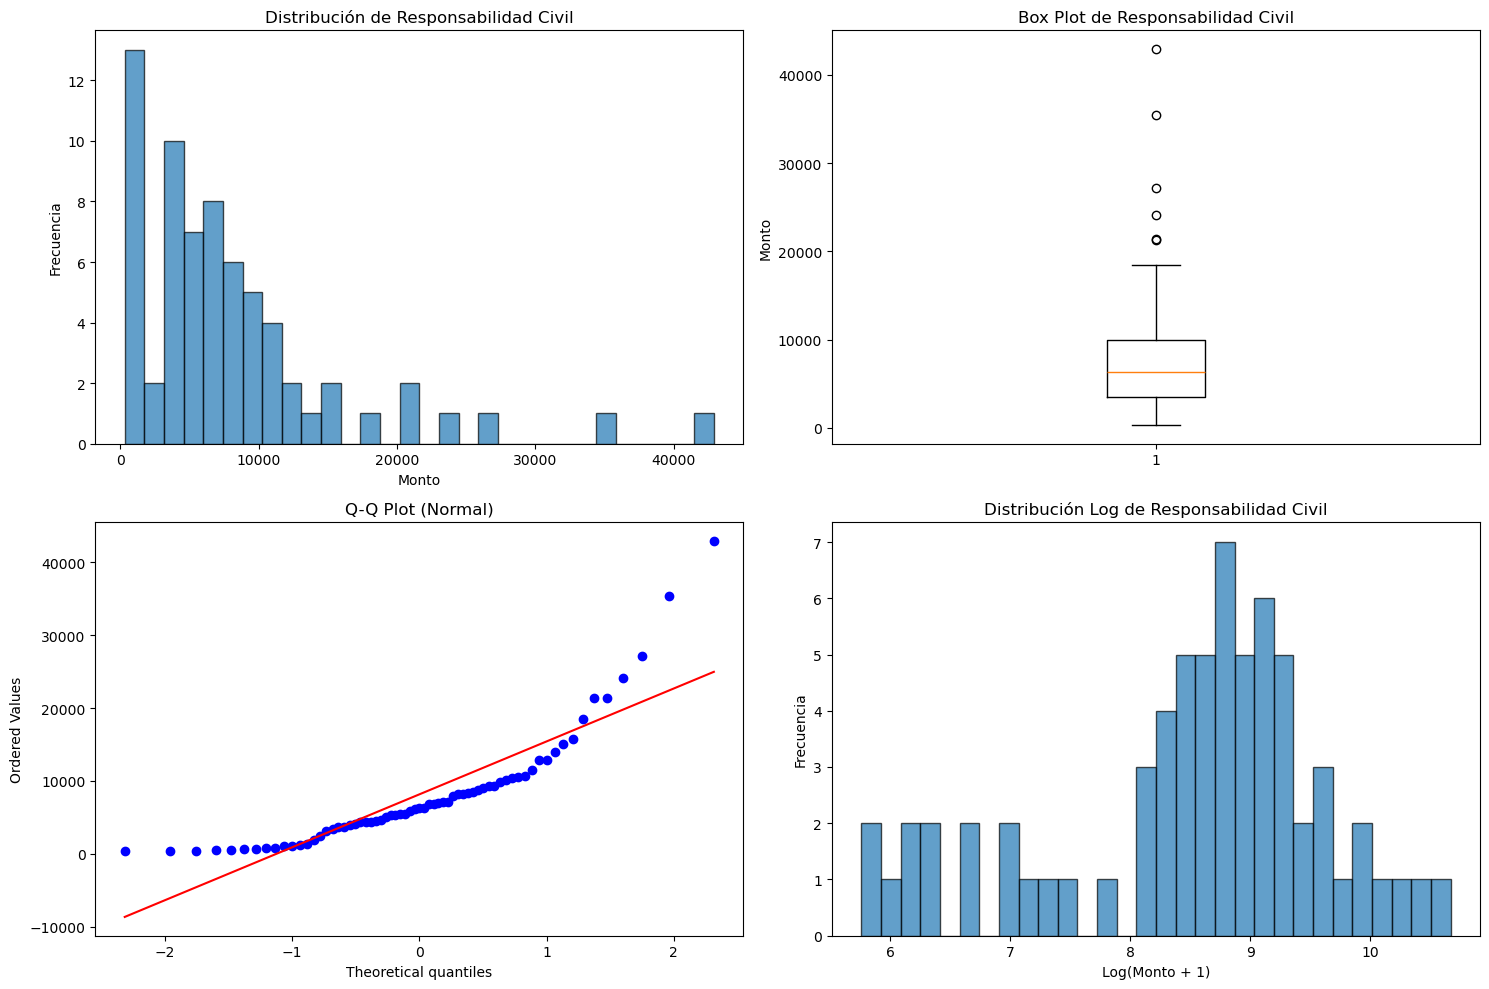

In [4]:
# Análisis de la variable objetivo
target_var = 'Resp_Civil_siniestros_monto'

print(f"Estadísticas de {target_var}:")
print(f"Media: ${data[target_var].mean():,.2f}")
print(f"Mediana: ${data[target_var].median():,.2f}")
print(f"Desviación estándar: ${data[target_var].std():,.2f}")
print(f"Mínimo: ${data[target_var].min():,.2f}")
print(f"Máximo: ${data[target_var].max():,.2f}")
print(f"Asimetría: {data[target_var].skew():.3f}")
print(f"Curtosis: {data[target_var].kurtosis():.3f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
axes[0,0].hist(data[target_var], bins=30, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribución de Responsabilidad Civil')
axes[0,0].set_xlabel('Monto')
axes[0,0].set_ylabel('Frecuencia')

# Box plot
axes[0,1].boxplot(data[target_var])
axes[0,1].set_title('Box Plot de Responsabilidad Civil')
axes[0,1].set_ylabel('Monto')

# Q-Q plot
stats.probplot(data[target_var], dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (Normal)')

# Log scale histogram
axes[1,1].hist(np.log(data[target_var] + 1), bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Distribución Log de Responsabilidad Civil')
axes[1,1].set_xlabel('Log(Monto + 1)')
axes[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

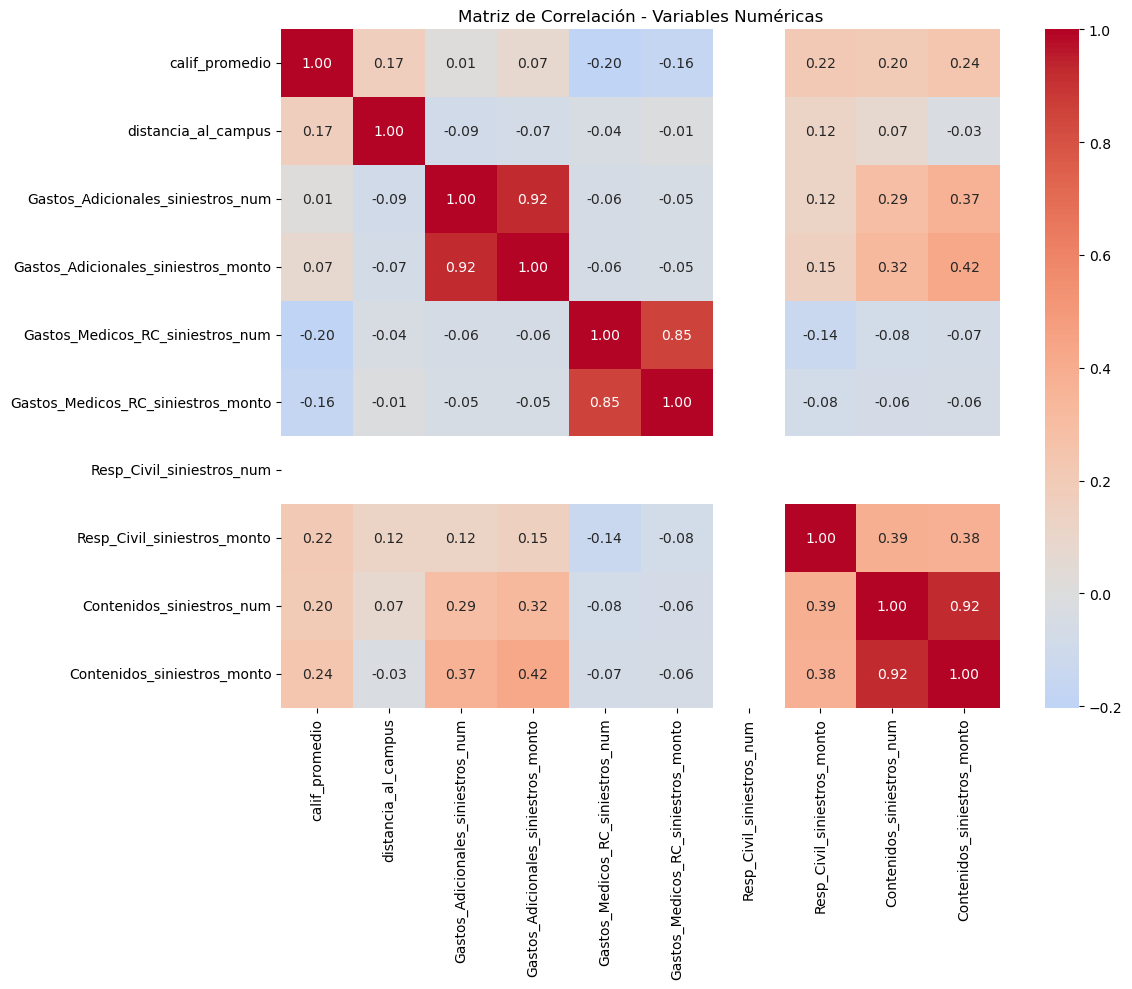


Correlaciones con Resp_Civil_siniestros_monto:
Contenidos_siniestros_num              0.39
Contenidos_siniestros_monto            0.38
calif_promedio                         0.22
Gastos_Adicionales_siniestros_monto    0.15
Gastos_Medicos_RC_siniestros_num      -0.14
Gastos_Adicionales_siniestros_num      0.12
distancia_al_campus                    0.12
Gastos_Medicos_RC_siniestros_monto    -0.08
Resp_Civil_siniestros_num               NaN
Name: Resp_Civil_siniestros_monto, dtype: float64


In [5]:
# Análisis de correlación con variables numéricas
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = data[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

# Correlaciones con la variable objetivo
target_corr = correlation_matrix[target_var].drop(target_var).sort_values(key=abs, ascending=False)
print(f"\nCorrelaciones con {target_var}:")
print(target_corr)

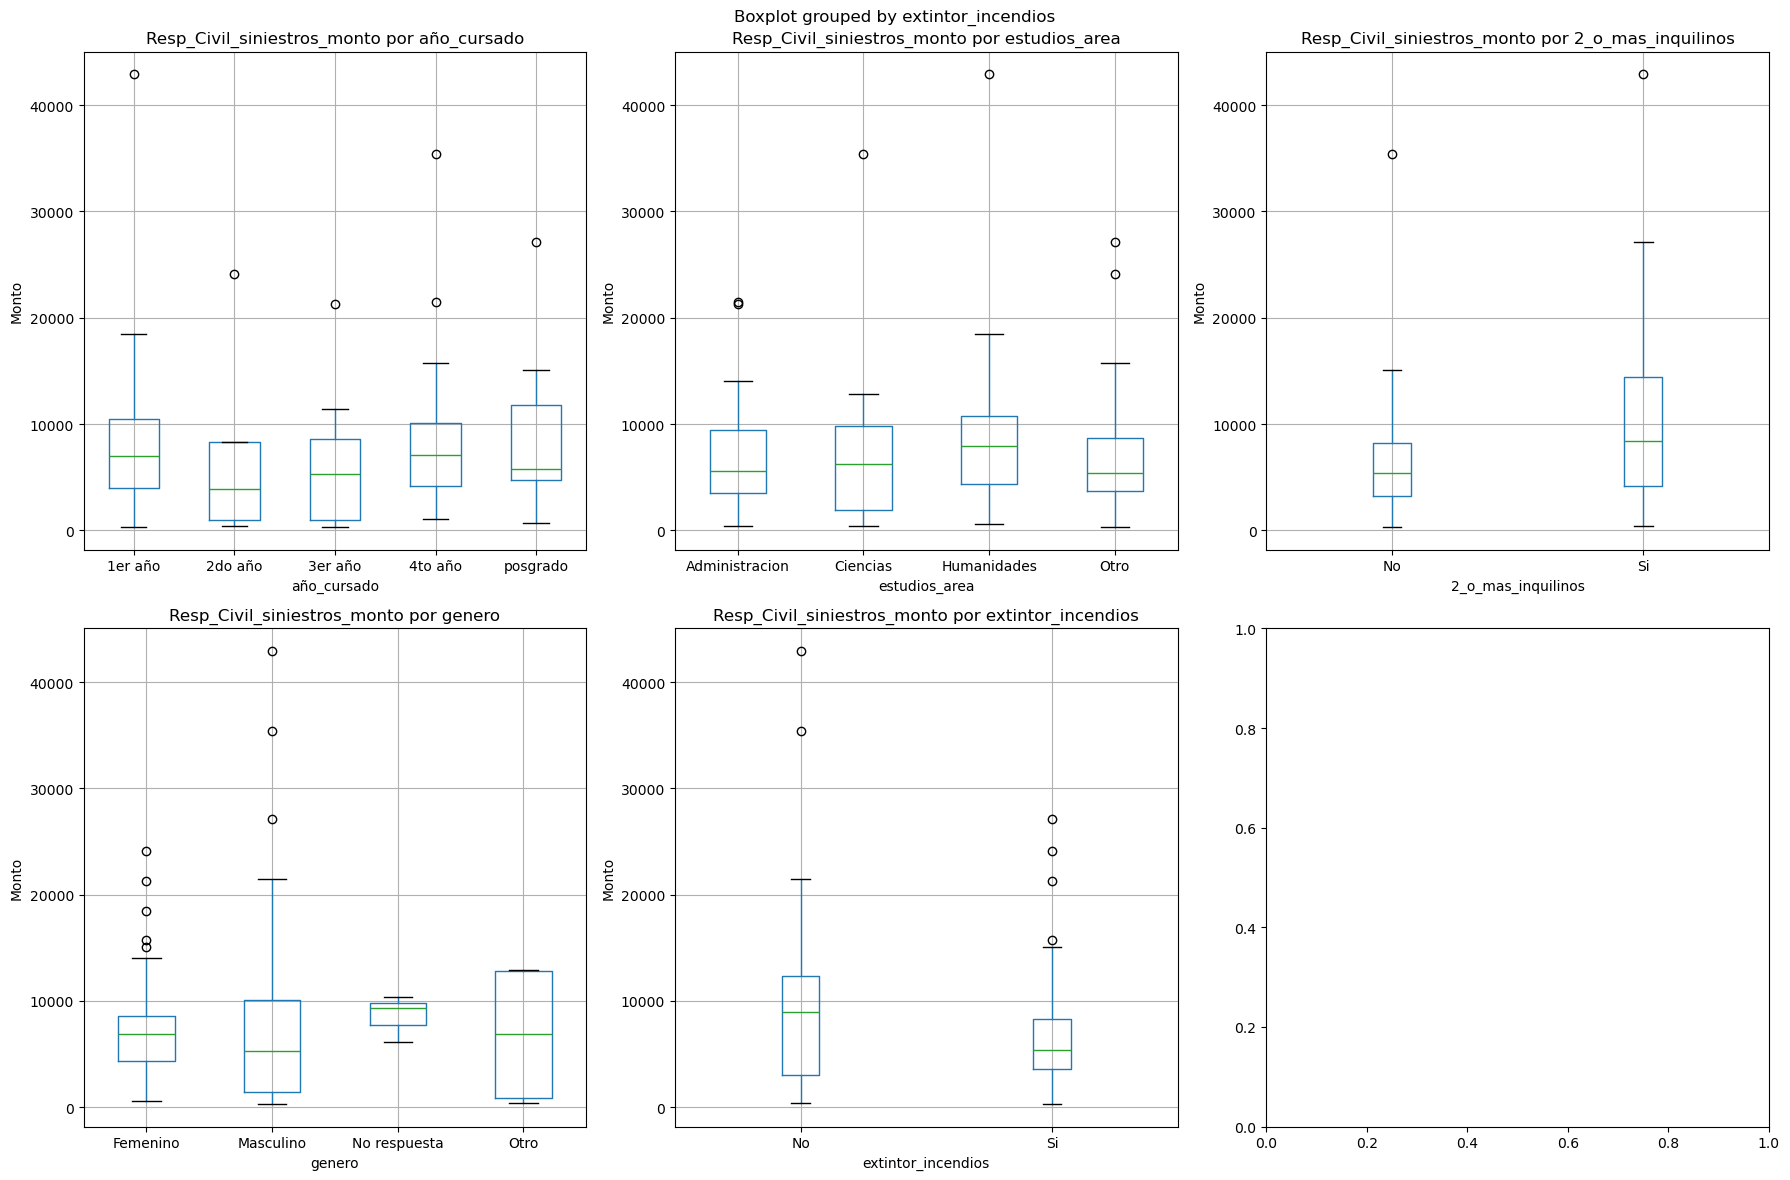


Estadísticas de Resp_Civil_siniestros_monto por año_cursado:
             count    mean  median     std
año_cursado                               
1er año         22 8832.92 6964.09 8895.86
2do año          8 6310.11 3870.14 7982.38
3er año         15 5902.19 5328.92 5603.63
4to año         14 9882.83 7048.01 9107.42
posgrado         8 9301.38 5813.22 8431.64

Estadísticas de Resp_Civil_siniestros_monto por estudios_area:
                count    mean  median      std
estudios_area                                 
Administracion     20 7164.25 5566.73  6181.10
Ciencias           15 7906.90 6284.07  8624.66
Humanidades        15 9797.65 7963.59 10474.42
Otro               17 8073.85 5422.90  7602.54

Estadísticas de Resp_Civil_siniestros_monto por 2_o_mas_inquilinos:
                    count     mean  median      std
2_o_mas_inquilinos                                 
No                     41  6530.29 5422.90  6108.38
Si                     26 10706.41 8429.89 10038.41

Estadísticas 

In [6]:
# Análisis por variables categóricas
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols[:6]):
    if i < len(axes):
        data.boxplot(column=target_var, by=col, ax=axes[i])
        axes[i].set_title(f'{target_var} por {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Monto')

plt.tight_layout()
plt.show()

# Estadísticas por categoría
for col in categorical_cols:
    print(f"\nEstadísticas de {target_var} por {col}:")
    print(data.groupby(col)[target_var].agg(['count', 'mean', 'median', 'std']).round(2))

In [7]:
# Preparación de datos
# Definir características y variable objetivo
feature_cols = [col for col in data.columns if col != target_var]
X = data[feature_cols].copy()
y = data[target_var].copy()

print(f"Características: {len(feature_cols)}")
print(f"Registros: {len(X)}")
print(f"\nCaracterísticas disponibles:")
print(feature_cols)

# Codificar variables categóricas
label_encoders = {}
categorical_features = X.select_dtypes(include=['object']).columns

for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print(f"\nVariables categóricas codificadas: {list(categorical_features)}")
print(f"Forma final de X: {X.shape}")
print(f"Forma de y: {y.shape}")

Características: 14
Registros: 67

Características disponibles:
['año_cursado', 'estudios_area', 'calif_promedio', '2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios', 'Gastos_Adicionales_siniestros_num', 'Gastos_Adicionales_siniestros_monto', 'Gastos_Medicos_RC_siniestros_num', 'Gastos_Medicos_RC_siniestros_monto', 'Resp_Civil_siniestros_num', 'Contenidos_siniestros_num', 'Contenidos_siniestros_monto']

Variables categóricas codificadas: ['año_cursado', 'estudios_area', '2_o_mas_inquilinos', 'genero', 'extintor_incendios']
Forma final de X: (67, 14)
Forma de y: (67,)


In [8]:
# Selección de variables con GLM LogNormal y Gamma por separado
print("=== SELECCIÓN DE VARIABLES ===")

# Estandarizar características para selección
scaler_selection = StandardScaler()
X_scaled = scaler_selection.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Definir número objetivo de características (40% del total)
n_features_target = max(5, int(0.4 * len(feature_cols)))
print(f"Número objetivo de características: {n_features_target}")

# 1. Selección con GLM LogNormal (TweedieRegressor con power=0)
print("\n1. Selección de variables con GLM LogNormal...")
lognormal_model = TweedieRegressor(power=0, alpha=0.1, link='log', max_iter=1000)
rfe_lognormal = RFE(estimator=lognormal_model, n_features_to_select=n_features_target, step=1)
rfe_lognormal.fit(X_scaled_df, y)

# Obtener características seleccionadas por LogNormal
lognormal_features = X.columns[rfe_lognormal.support_].tolist()
print(f"Características seleccionadas por LogNormal: {lognormal_features}")

# Evaluar modelo LogNormal
X_lognormal = X_scaled_df[lognormal_features]
lognormal_scores = cross_val_score(lognormal_model, X_lognormal, y, 
                                   cv=5, scoring='neg_mean_absolute_error')
lognormal_mae = -lognormal_scores.mean()
print(f"MAE promedio con LogNormal: {lognormal_mae:.2f}")

# 2. Selección con GLM Gamma
print("\n2. Selección de variables con GLM Gamma...")
gamma_model = GammaRegressor(alpha=0.1, max_iter=1000)
rfe_gamma = RFE(estimator=gamma_model, n_features_to_select=n_features_target, step=1)
rfe_gamma.fit(X_scaled_df, y)

# Obtener características seleccionadas por Gamma
gamma_features = X.columns[rfe_gamma.support_].tolist()
print(f"Características seleccionadas por Gamma: {gamma_features}")

# Evaluar modelo Gamma
X_gamma = X_scaled_df[gamma_features]
gamma_scores = cross_val_score(gamma_model, X_gamma, y, 
                               cv=5, scoring='neg_mean_absolute_error')
gamma_mae = -gamma_scores.mean()
print(f"MAE promedio con Gamma: {gamma_mae:.2f}")

# Seleccionar el mejor conjunto de características
if lognormal_mae < gamma_mae:
    best_features = lognormal_features
    best_method = "LogNormal"
    best_mae = lognormal_mae
else:
    best_features = gamma_features
    best_method = "Gamma"
    best_mae = gamma_mae

print(f"\n=== RESULTADO DE SELECCIÓN ===")
print(f"Mejor método: {best_method}")
print(f"MAE: {best_mae:.2f}")
print(f"Características seleccionadas: {best_features}")

# Usar las mejores características para el resto del análisis
selected_features = best_features
X_selected = X[selected_features].copy()

=== SELECCIÓN DE VARIABLES ===
Número objetivo de características: 5

1. Selección de variables con GLM LogNormal...
Características seleccionadas por LogNormal: ['estudios_area', 'calif_promedio', '2_o_mas_inquilinos', 'Contenidos_siniestros_num', 'Contenidos_siniestros_monto']
MAE promedio con LogNormal: 6853.23

2. Selección de variables con GLM Gamma...
Características seleccionadas por Gamma: ['2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios', 'Gastos_Medicos_RC_siniestros_num']
MAE promedio con Gamma: 5581.67

=== RESULTADO DE SELECCIÓN ===
Mejor método: Gamma
MAE: 5581.67
Características seleccionadas: ['2_o_mas_inquilinos', 'distancia_al_campus', 'genero', 'extintor_incendios', 'Gastos_Medicos_RC_siniestros_num']


In [9]:
# División train/test con características seleccionadas
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {X_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}")

# Estandarizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nDatos estandarizados y listos para modelación")

Conjunto de entrenamiento: (53, 5)
Conjunto de prueba: (14, 5)

Datos estandarizados y listos para modelación


In [10]:
# LazyPredict para encontrar mejores modelos
print("=== EVALUACIÓN CON LAZYPREDICT ===")

lazy_regressor = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = lazy_regressor.fit(X_train_scaled, X_test_scaled, y_train, y_test)

print("Resultados de LazyPredict:")
print(models.head(10))

# Obtener los 5 mejores modelos por R²
top_models = models.head(5).index.tolist()
print(f"\nTop 5 modelos: {top_models}")

=== EVALUACIÓN CON LAZYPREDICT ===


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 2
[LightGBM] [Info] Start training from score 6282.114741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [11]:
# Configuración de modelos para Grid Search
# Incluir modelos de LazyPredict + modelos GLM obligatorios

models_config = {
    # Modelos GLM obligatorios
    'TweedieRegressor_LogNormal': {
        'model': TweedieRegressor(power=0, link='log', max_iter=1000),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['lbfgs', 'newton-cholesky']
        }
    },
    'GammaRegressor': {
        'model': GammaRegressor(max_iter=1000),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'solver': ['lbfgs', 'newton-cholesky']
        }
    },
    # Modelos comunes para severidad
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'ExtraTreesRegressor': {
        'model': ExtraTreesRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'HuberRegressor': {
        'model': HuberRegressor(max_iter=1000),
        'params': {
            'epsilon': [1.35, 1.5, 1.75, 2.0],
            'alpha': [0.0001, 0.001, 0.01, 0.1]
        }
    }
}

print(f"Modelos configurados para Grid Search: {list(models_config.keys())}")

Modelos configurados para Grid Search: ['TweedieRegressor_LogNormal', 'GammaRegressor', 'RandomForestRegressor', 'GradientBoostingRegressor', 'ExtraTreesRegressor', 'HuberRegressor']


In [12]:
# Grid Search con Cross Validation
print("=== GRID SEARCH CON CROSS VALIDATION ===")

# Configuración de CV
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

# Función para calcular coeficiente de Gini
def gini_coefficient(y_true, y_pred):
    if len(y_true) != len(y_pred):
        return 0
    
    # Crear DataFrame y ordenar por predicciones
    df = pd.DataFrame({'actual': y_true, 'predicted': y_pred})
    df = df.sort_values('predicted')
    
    # Calcular Gini
    n = len(df)
    cumsum_actual = df['actual'].cumsum()
    total_actual = df['actual'].sum()
    
    if total_actual == 0:
        return 0
    
    gini = (n + 1 - 2 * sum(cumsum_actual) / total_actual) / n
    return gini

# Procesar cada modelo
for model_name, config in models_config.items():
    print(f"\nOptimizando {model_name}...")
    
    try:
        # Configurar RandomizedSearchCV
        random_search = RandomizedSearchCV(
            estimator=config['model'],
            param_distributions=config['params'],
            n_iter=20,  # Reducir iteraciones para velocidad
            cv=cv_folds,
            scoring='neg_mean_absolute_error',
            random_state=42,
            n_jobs=-1
        )
        
        # Entrenar
        random_search.fit(X_train_scaled, y_train)
        
        # Mejor modelo
        best_model = random_search.best_estimator_
        
        # Predicciones en test
        y_pred = best_model.predict(X_test_scaled)
        
        # Validar predicciones
        if np.any(np.isnan(y_pred)) or np.any(np.isinf(y_pred)):
            print(f"  ⚠️  Predicciones inválidas detectadas para {model_name}")
            continue
        
        # Calcular métricas
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        gini = gini_coefficient(y_test.values, y_pred)
        
        # Guardar resultados
        results.append({
            'Modelo': model_name,
            'MAE': mae,
            'R²': r2,
            'RMSE': rmse,
            'Gini': gini,
            'Mejores_Params': random_search.best_params_,
            'Model_Object': best_model
        })
        
        print(f"  ✓ {model_name}: MAE={mae:.2f}, R²={r2:.3f}, Gini={gini:.3f}")
        
    except Exception as e:
        print(f"  ❌ Error con {model_name}: {str(e)}")
        continue

# Crear DataFrame con resultados
if results:
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('MAE')  # Ordenar por MAE (menor es mejor)
    
    print("\n=== RESULTADOS FINALES ===")
    display_cols = ['Modelo', 'MAE', 'R²', 'RMSE', 'Gini']
    print(results_df[display_cols].to_string(index=False, float_format='%.3f'))
else:
    print("❌ No se pudieron entrenar modelos exitosamente")

=== GRID SEARCH CON CROSS VALIDATION ===

Optimizando TweedieRegressor_LogNormal...
  ✓ TweedieRegressor_LogNormal: MAE=9984.72, R²=-0.395, Gini=0.092

Optimizando GammaRegressor...
  ✓ GammaRegressor: MAE=9988.69, R²=-0.486, Gini=0.026

Optimizando RandomForestRegressor...
  ✓ RandomForestRegressor: MAE=9264.78, R²=-0.309, Gini=0.124

Optimizando GradientBoostingRegressor...
  ✓ GradientBoostingRegressor: MAE=9300.94, R²=-0.303, Gini=0.051

Optimizando ExtraTreesRegressor...
  ✓ ExtraTreesRegressor: MAE=8147.40, R²=-0.075, Gini=0.183

Optimizando HuberRegressor...
  ✓ HuberRegressor: MAE=10251.16, R²=-0.548, Gini=-0.061

=== RESULTADOS FINALES ===
                    Modelo       MAE     R²      RMSE   Gini
       ExtraTreesRegressor  8147.398 -0.075 12413.360  0.183
     RandomForestRegressor  9264.778 -0.309 13698.219  0.124
 GradientBoostingRegressor  9300.943 -0.303 13664.782  0.051
TweedieRegressor_LogNormal  9984.716 -0.395 14142.604  0.092
            GammaRegressor  9988.693 -

In [13]:
# Seleccionar y guardar el mejor modelo
if results:
    # El mejor modelo es el que tiene menor MAE
    best_result = results_df.iloc[0]
    best_model_name = best_result['Modelo']
    best_model = best_result['Model_Object']
    
    print(f"=== MEJOR MODELO: {best_model_name} ===")
    print(f"MAE: {best_result['MAE']:.2f}")
    print(f"R²: {best_result['R²']:.3f}")
    print(f"RMSE: {best_result['RMSE']:.2f}")
    print(f"Gini: {best_result['Gini']:.3f}")
    print(f"Parámetros: {best_result['Mejores_Params']}")
    
    # Guardar modelo, scaler y características seleccionadas
    import os
    os.makedirs('/home/ge-murillo/Proyectos/competencia-cas-2025/models', exist_ok=True)
    
    # Guardar modelo
    joblib.dump(best_model, '/home/ge-murillo/Proyectos/competencia-cas-2025/models/severidad_rc_model.pkl')
    
    # Guardar scaler
    joblib.dump(scaler, '/home/ge-murillo/Proyectos/competencia-cas-2025/models/severidad_rc_scaler.pkl')
    
    # Guardar características seleccionadas
    joblib.dump(selected_features, '/home/ge-murillo/Proyectos/competencia-cas-2025/models/severidad_rc_features.pkl')
    
    # Guardar label encoders
    joblib.dump(label_encoders, '/home/ge-murillo/Proyectos/competencia-cas-2025/models/severidad_rc_encoders.pkl')
    
    print(f"\n✓ Modelo guardado en: models/severidad_rc_model.pkl")
    print(f"✓ Scaler guardado en: models/severidad_rc_scaler.pkl")
    print(f"✓ Características guardadas en: models/severidad_rc_features.pkl")
    print(f"✓ Encoders guardados en: models/severidad_rc_encoders.pkl")
else:
    print("❌ No hay resultados para guardar")

=== MEJOR MODELO: ExtraTreesRegressor ===
MAE: 8147.40
R²: -0.075
RMSE: 12413.36
Gini: 0.183
Parámetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5}

✓ Modelo guardado en: models/severidad_rc_model.pkl
✓ Scaler guardado en: models/severidad_rc_scaler.pkl
✓ Características guardadas en: models/severidad_rc_features.pkl
✓ Encoders guardados en: models/severidad_rc_encoders.pkl


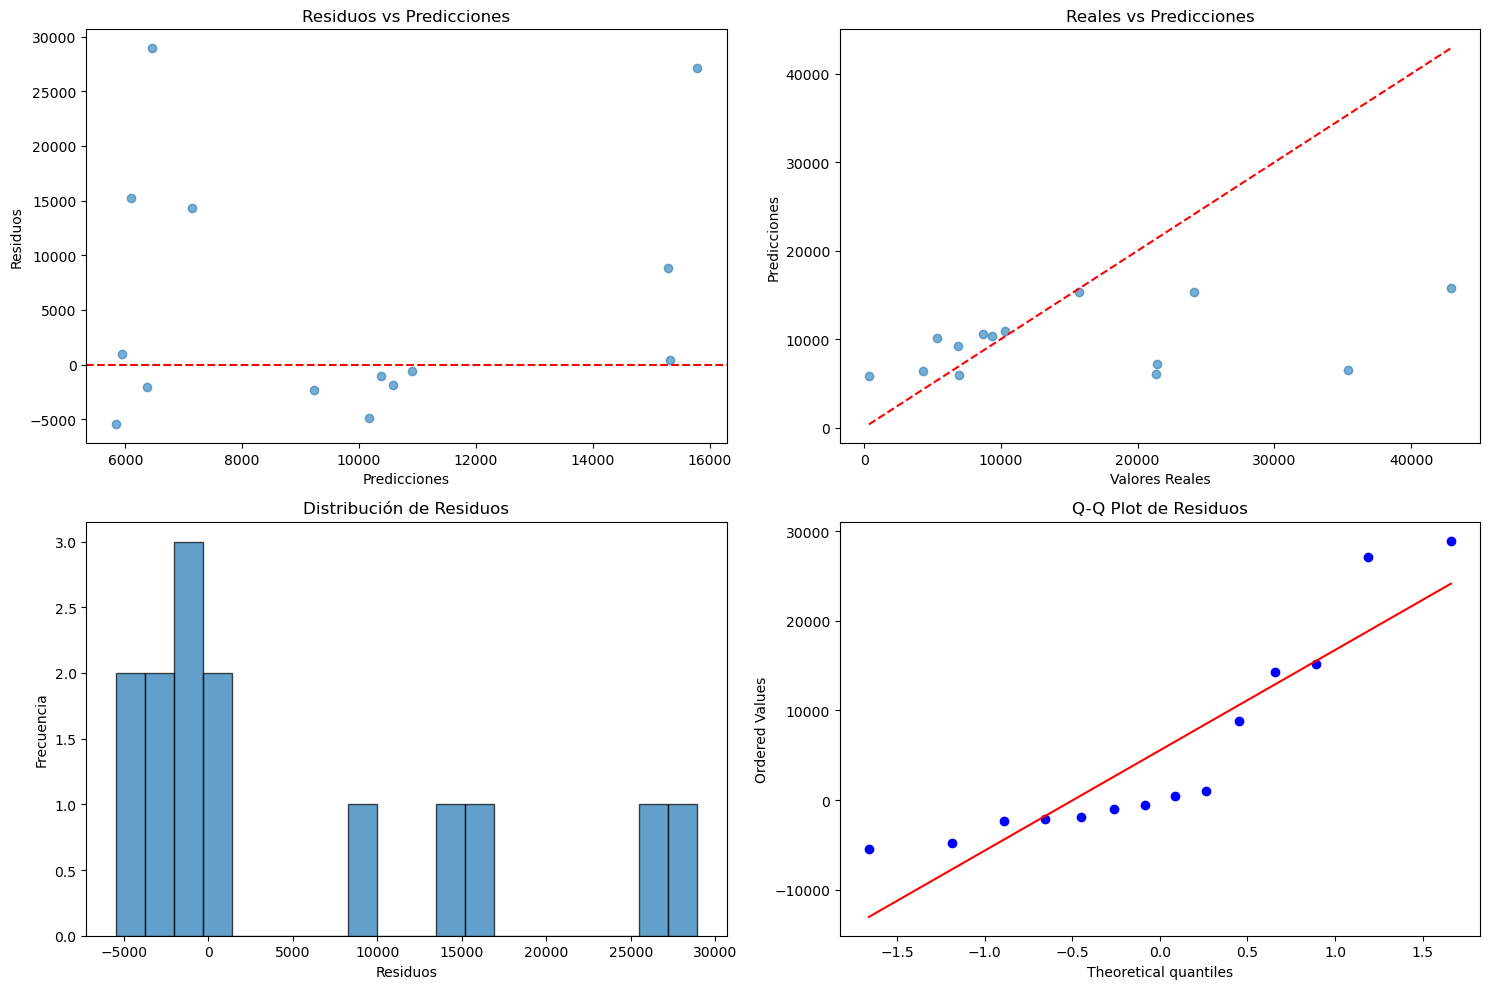


Análisis de residuos completado para ExtraTreesRegressor
Media de residuos: 5547.143
Desviación estándar de residuos: 11524.189


In [14]:
# Análisis de residuos del mejor modelo
if results:
    y_pred_best = best_model.predict(X_test_scaled)
    residuals = y_test - y_pred_best
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Residuos vs predicciones
    axes[0,0].scatter(y_pred_best, residuals, alpha=0.6)
    axes[0,0].axhline(y=0, color='red', linestyle='--')
    axes[0,0].set_xlabel('Predicciones')
    axes[0,0].set_ylabel('Residuos')
    axes[0,0].set_title('Residuos vs Predicciones')
    
    # Valores reales vs predicciones
    axes[0,1].scatter(y_test, y_pred_best, alpha=0.6)
    min_val = min(y_test.min(), y_pred_best.min())
    max_val = max(y_test.max(), y_pred_best.max())
    axes[0,1].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--')
    axes[0,1].set_xlabel('Valores Reales')
    axes[0,1].set_ylabel('Predicciones')
    axes[0,1].set_title('Reales vs Predicciones')
    
    # Histograma de residuos
    axes[1,0].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Residuos')
    axes[1,0].set_ylabel('Frecuencia')
    axes[1,0].set_title('Distribución de Residuos')
    
    # Q-Q plot de residuos
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot de Residuos')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnálisis de residuos completado para {best_model_name}")
    print(f"Media de residuos: {residuals.mean():.3f}")
    print(f"Desviación estándar de residuos: {residuals.std():.3f}")